## Softmax Wildfire Prediction – Summary

- Loads softmax outputs from multiple models (CNN, MLP, GRU, etc.).
- Visualizes softmax probabilities on geographic maps using Cartopy.
- Supports label filtering (all, positive, negative) via interactive widgets.
- Saves map plots for all model-label combinations.
- Optionally interpolates softmax values to smooth spatial patterns.
- Compares softmax outputs for selected sample IDs across models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets

In [2]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"
model_names = ['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft']
data_dict = {}

for model in model_names:
    file = f"test_softmax_outputs_{model}.csv"
    data_dict[model] = pd.read_csv(f"{path}/{file}")
print(data_dict.keys())

dict_keys(['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft'])


In [3]:
#only change the model name here
model = "transformer"

In [4]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"
file = f"test_softmax_outputs_{model}.csv"

In [5]:
df = pd.read_csv(f"{path}/{file}")

In [29]:
false_positive_sample_ids = [
    16233, 15538, 15330, 15494, 16849, 15341, 17076, 16985, 16861, 15569,
    16701, 16838, 16896, 15759, 15687, 15391, 15593, 16919, 17079, 15647,
    14748, 15306, 14825, 17031, 16696, 16781, 16917, 16829, 16787, 15639,
    15767, 17000, 15624, 17028, 15499, 15559, 15621, 16823, 15812, 15459,
    15390, 15406, 17050, 16735, 15659, 15334, 15600, 15603, 16736, 15557,
    15452, 16789, 15356, 16996, 15382, 17226, 15397, 17038, 15758, 16688,
    17179, 17024, 15577, 17040, 17191, 15318, 15420, 15656, 15376, 15617,
    16949, 17139, 17001, 16886, 16687, 15503, 15466, 16713, 17007, 15398,
    16577, 15508, 15380, 15229, 16802, 15530, 16856, 15502, 15319, 16983,
    16940, 16938, 16810, 15324, 17059, 17215, 16754, 15400, 16897, 15572
]

false_positive_df = df[df['sample_id'].isin(false_positive_sample_ids)]
false_positive_df

,prob,lat,lon,sample_id,label,log_burned_area
62,0.939368,8.985880,41.869305,16849,0,3.401197
248,0.982514,1.363669,36.270957,16713,0,3.401197
256,0.992956,3.629187,36.633440,16886,0,3.401197
398,0.862179,8.844915,42.483513,15508,0,3.401197
466,0.868662,35.900242,35.616474,16983,0,3.401197
...,...,...,...,...,...,...
3989,0.809205,22.599130,41.013443,16940,0,3.401197
4005,0.886773,-6.147784,33.542266,15687,0,3.401197
4068,0.938974,13.315538,43.369582,17007,0,3.401197
4076,0.882226,19.930853,40.036752,15759,0,3.401197


In [23]:
false_negative_sample_ids = [
    8449, 3713, 625, 4152, 4892, 6519, 8453, 8523, 6692, 6079, 3126, 671, 8448, 3131, 2952, 4801,
    4835, 4894, 4433, 4428, 5977, 6040, 3908, 702, 4800, 4832, 3920, 670, 3901, 4798, 3933, 6682,
    719, 8374, 1608, 661, 3080, 630, 3651, 3932, 6201, 3730, 3904, 2970, 701, 622, 1619, 1656, 6699,
    4422, 4836, 1639, 643, 3650, 4888, 6582, 8475, 5971, 2957, 8344, 6200, 6694, 1645, 665, 4893,
    3711, 6701, 5978, 2959, 4839, 6210, 5962, 632, 6121, 6067, 707, 3708, 3190, 3738, 6090, 4459,
    658, 3911, 1634, 5956, 3224, 2976, 3917, 623, 6522, 1642, 4927, 3912, 4806, 2962, 640, 1610,
    631, 8561, 8562
]
false_negative_df = df[df['sample_id'].isin(false_negative_sample_ids)]
false_negative_df

,prob,lat,lon,sample_id,label,log_burned_area
1,0.039254,14.080780,42.201581,3708,1,4.682131
8,0.013475,35.819690,34.075921,6701,1,3.891820
51,0.023716,16.457057,39.925994,3080,1,4.795791
115,0.044427,29.355410,36.301164,4798,1,5.726848
116,0.036183,-6.389439,38.959372,632,1,5.680172
...,...,...,...,...,...,...
3939,0.002497,8.089742,43.963651,3650,1,4.110874
3981,0.058325,22.568923,41.547098,4832,1,3.828641
3993,0.078585,29.194307,39.422545,6210,1,5.552959
4024,0.309016,21.008233,41.023512,6522,1,3.496508


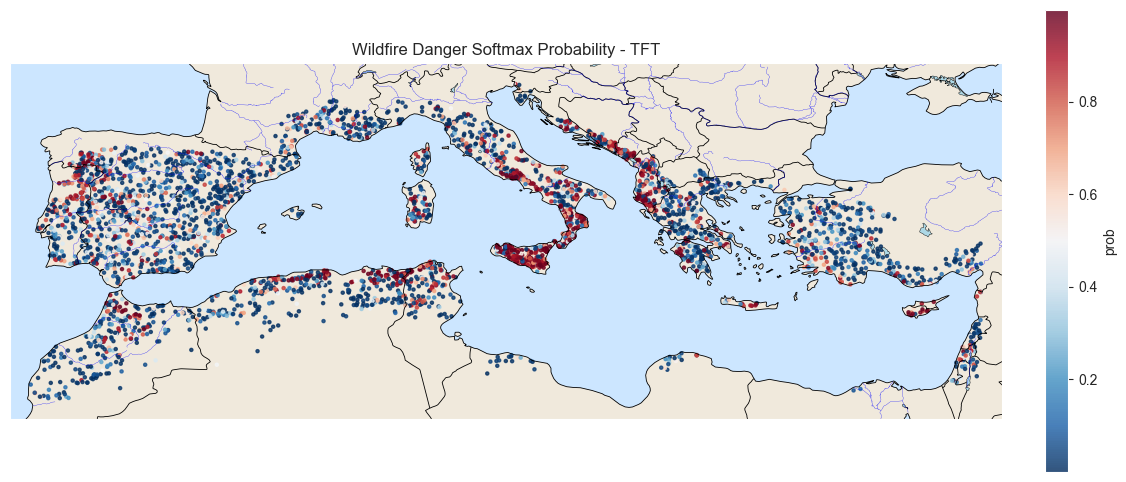

In [43]:
x = df['lat']
y = df['lon']
influence_variable = df['prob'] #softmax probability of each validation sample

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([x.min() - 1, x.max() + 1, y.min() - 1, y.max() + 1], crs=ccrs.PlateCarree())
#ax.stock_img()

ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

sc = ax.scatter(x, y, c=influence_variable, cmap='RdBu_r', s=5, alpha=0.8, vmin=influence_variable.min(), vmax=influence_variable.max(), transform=ccrs.PlateCarree())

cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cb.set_label(f'{influence_variable.name}')

plt.title("Wildfire Danger Softmax Probability - TFT")

plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
import os
from IPython.display import display
import ipywidgets as widgets

path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"

model_names = ['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft']

model_selector = widgets.Dropdown(
    options=model_names,
    value="transformer",
    description="Model:"
)

label_selector = widgets.Dropdown(
    options=["all", "positive", "negative"],
    value="all",
    description="Label:"
)

def plot_softmax_map(model, label_filter):
    file = f"test_softmax_outputs_{model}.csv"
    filepath = os.path.join(path, file)

    if not os.path.exists(filepath):
        print(f"File not found for model: {model}")
        return

    df = pd.read_csv(filepath)
    df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)

    if label_filter == "positive":
        data = df[df["label"] == 1]
    elif label_filter == "negative":
        data = df[df["label"] == 0]
    else:
        data = df

    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([data["lat"].min() - 1, data["lat"].max() + 1,
                   data["lon"].min() - 1, data["lon"].max() + 1],
                  crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#FBF7EB') #FBFFCA hellgalb, #f0e9dc beige, #FBF7EB light beige
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.4)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#3B65DB', linewidth=0.5)

    sc = ax.scatter(
        data["lat"], data["lon"],
        c=data["prob"],
        cmap='coolwarm', #Spectral_r, turbo, RdBu_r
        s=5, alpha=0.8,
        vmin=df["prob"].min(), vmax=df["prob"].max(),
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label("Softmax Probability")

    plt.title(None)
    plt.title(f"Wildfire Danger Softmax Probability - {model.upper()} ({label_filter})")
    plt.show()

widgets.interact(plot_softmax_map, model=model_selector, label_filter=label_selector);


interactive(children=(Dropdown(description='Model:', index=4, options=('cnn', 'mlp', 'gru', 'lstm', 'transform…

In [33]:
input_path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"
output_path = "/Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots"
os.makedirs(output_path, exist_ok=True)

model_names = ['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft']
label_options = ["all", "positive", "negative"]

def plot_and_save_softmax_map(model, label_filter):
    file = f"test_softmax_outputs_{model}.csv"
    filepath = os.path.join(input_path, file)

    if not os.path.exists(filepath):
        print(f"File not found for model: {model}")
        return

    df = pd.read_csv(filepath)
    df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)

    if label_filter == "positive":
        data = df[df["label"] == 1]
    elif label_filter == "negative":
        data = df[df["label"] == 0]
    else:
        data = df

    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([data["lat"].min() - 1, data["lat"].max() + 1,
                   data["lon"].min() - 1, data["lon"].max() + 1],
                  crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')  # FBFFCA hellgalb, #f0e9dc beige
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.4)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#3B65DB', linewidth=0.5)

    sc = ax.scatter(
        data["lat"], data["lon"],
        c=data["prob"],
        cmap='coolwarm',  # Spectral_r, turbo, RdBu_r
        s=5, alpha=0.8,
        vmin=df["prob"].min(), vmax=df["prob"].max(),
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label("Softmax Probability")

    if model != "transformer":
        model = model.upper()
    else: 
        model = "Transformer"
    plt.title(None)

    filename = f"softmax_map_{model}_{label_filter}_beige_dark.png"
    save_path = os.path.join(output_path, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[✓] Saved plot: {save_path}")

for model in model_names:
    for label in label_options:
        plot_and_save_softmax_map(model, label)

[✓] Saved plot: /Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots/softmax_map_CNN_all_beige_dark.png
[✓] Saved plot: /Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots/softmax_map_CNN_positive_beige_dark.png
[✓] Saved plot: /Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots/softmax_map_CNN_negative_beige_dark.png
[✓] Saved plot: /Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots/softmax_map_MLP_all_beige_dark.png
[✓] Saved plot: /Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Softmax_plots/softmax_map_MLP_positive_beige_dark.png
[✓] S

In [34]:
from scipy.interpolate import griddata

def plot_softmax_map(model, label_filter):
    file = f"test_softmax_outputs_{model}.csv"
    filepath = os.path.join(path, file)

    if not os.path.exists(filepath):
        print(f"File not found for model: {model}")
        return

    df = pd.read_csv(filepath)
    df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)

    if label_filter == "positive":
        data = df[df["label"] == 1]
    elif label_filter == "negative":
        data = df[df["label"] == 0]
    else:
        data = df

    grid_lon = np.linspace(data["lon"].min(), data["lon"].max(), 500)  # X-Achse
    grid_lat = np.linspace(data["lat"].min(), data["lat"].max(), 500)  # Y-Achse
    #grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    lon_min, lon_max = -10, 40    # z. B. von Spanien bis Türkei
    lat_min, lat_max = 30, 50     # z. B. Nordafrika bis Mitteleuropa
    
    grid_lon = np.linspace(lon_min, lon_max, 500)
    grid_lat = np.linspace(lat_min, lat_max, 500)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    grid_prob = griddata(
        (data["lon"], data["lat"]),
        data["prob"],
        (grid_lon, grid_lat),
        method='nearest'  # 'linear' oder 'cubic' können auch verwendet werden
    )

    masked_prob = np.ma.masked_invalid(grid_prob)

    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([data["lat"].min() - 1, data["lat"].max() + 1,
                   data["lon"].min() - 1, data["lon"].max() + 1],
                  crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

    im = ax.pcolormesh(
        grid_lon, grid_lat, masked_prob,
        cmap='RdBu_r',
        shading='auto',
        vmin=df["prob"].min(), vmax=df["prob"].max(),
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label("Softmax Probability")

    plt.title(f"Wildfire Danger Map - {model.upper()} ({label_filter})")
    plt.show()


In [10]:
sample_ids = [4792, 679, 8418, 1645, 1676]

for model in model_names:
    df = data_dict[model]
    selected_rows = df[df['sample_id'].isin(sample_ids)]
    print(f"\n{model.upper()} – Matching Samples:")
    print(selected_rows)



CNN – Matching Samples:
          prob        lat        lon  sample_id  label  log_burned_area
434   0.952787   4.172912  36.593164       8418      1        10.322230
529   0.270055  -6.218267  41.899512       1645      1        10.241601
650   0.992741  23.334165  38.818407       4792      1        10.844374
1910  0.413570  -6.037025  41.738409        679      1        10.389856
2312  0.812833  -7.497026  40.308615       1676      1        10.136977

MLP – Matching Samples:
          prob        lat        lon  sample_id  label  log_burned_area
800   0.992029  23.334165  38.818407       4792      1        10.844374
1362  0.772229  -7.497026  40.308615       1676      1        10.136977
1653  0.931372   4.172912  36.593164       8418      1        10.322230
1749  0.161926  -6.218267  41.899512       1645      1        10.241601
2781  0.319719  -6.037025  41.738409        679      1        10.389856

GRU – Matching Samples:
          prob        lat        lon  sample_id  label  log_b

In [35]:
data_dict['tft'][(data_dict['tft']['sample_id']==4792) | (data_dict['tft']['sample_id']==679) | (data_dict['tft']['sample_id']==8418) | (data_dict['tft']['sample_id']==1645) | (data_dict['tft']['sample_id']==1676)]

,prob,lat,lon,sample_id,label,log_burned_area
285,0.973704,4.172912,36.593164,8418,1,10.322230
940,0.182997,-6.218267,41.899512,1645,1,10.241601
1148,0.979553,23.334165,38.818407,4792,1,10.844374
2534,0.488200,-6.037025,41.738409,679,1,10.389856
2672,0.906081,-7.497026,40.308615,1676,1,10.136977
